## Project Goal

The goal of this project is to predict **Customer Lifetime Value (CLV)** based on purchasing history and demographic data. By leveraging time-series analysis, feature engineering, and regression modeling, the project aims to:

1. Estimate the lifetime value of each customer.
2. Highlight customers with high potential lifetime value.
3. Develop actionable strategies to retain and engage high-value customers.


## Libraries

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
#Mount Google Drive
drive.mount('/content/drive')

#Define the file path
file_path = '/content/drive/My Drive/marketing_campaign.csv'

#Load the dataset
df = pd.read_csv(file_path, delimiter='\t')
print(df.head())

Mounted at /content/drive
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  C

## Ridge Regression

In [18]:
# Preprocessing: Handle missing values
df = df.dropna(subset=['Income']).copy()  # Avoid chained assignment warning

# Feature Engineering
purchase_features = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]
df['Total_Spent'] = purchase_features.sum(axis=1)
df['Purchase_Frequency'] = (
    df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
)
df['Average_Order_Value'] = df['Total_Spent'] / df['Purchase_Frequency']
df['Recency'] = df['NumWebVisitsMonth']

# Replace infinities and drop invalid rows
df['Average_Order_Value'] = df['Average_Order_Value'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Average_Order_Value']).copy()

# Log-transform skewed variables
df['Average_Order_Value'] = np.log1p(df['Average_Order_Value'])

# Target Variable (CLV)
df['CLV'] = df['Total_Spent'] * df['Purchase_Frequency']

# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])  # Exclude non-numeric columns
print("Correlation with CLV:")
print(numeric_df.corr()['CLV'])

# Remove features directly related to CLV to avoid data leakage
features = ['Income', 'Recency', 'Average_Order_Value', 'Kidhome', 'Teenhome']
target = 'CLV'

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Ridge Regression model
model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Cross-Validation Score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validated R2 Scores: {cv_scores}")
print(f"Mean Cross-Validated R2: {np.mean(cv_scores):.2f}")

Correlation with CLV:
ID                    -0.018023
Year_Birth            -0.112845
Income                 0.640944
Kidhome               -0.519251
Teenhome              -0.087071
Recency               -0.434806
MntWines               0.864843
MntFruits              0.571249
MntMeatProducts        0.804465
MntFishProducts        0.598725
MntSweetProducts       0.578373
MntGoldProds           0.501532
NumDealsPurchases      0.031772
NumWebPurchases        0.582059
NumCatalogPurchases    0.816456
NumStorePurchases      0.725863
NumWebVisitsMonth     -0.434806
AcceptedCmp3           0.059239
AcceptedCmp4           0.219915
AcceptedCmp5           0.418588
AcceptedCmp1           0.358064
AcceptedCmp2           0.119838
Complain              -0.030048
Z_CostContact               NaN
Z_Revenue                   NaN
Response               0.237803
Total_Spent            0.958017
Purchase_Frequency     0.836358
Average_Order_Value    0.818501
CLV                    1.000000
Name: CLV, dtype: 

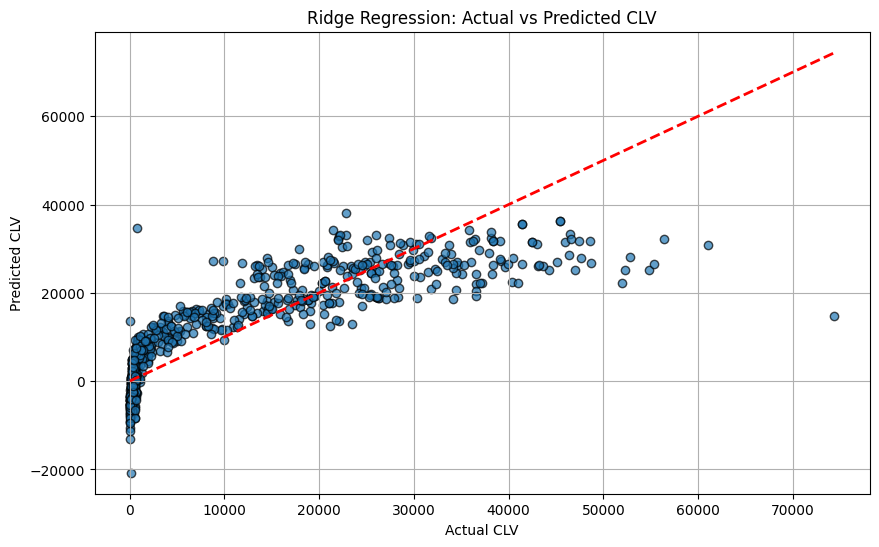

In [19]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Ridge Regression: Actual vs Predicted CLV')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.grid()
plt.show()

## Addressing Non-Linearity with Polynomial Regression

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

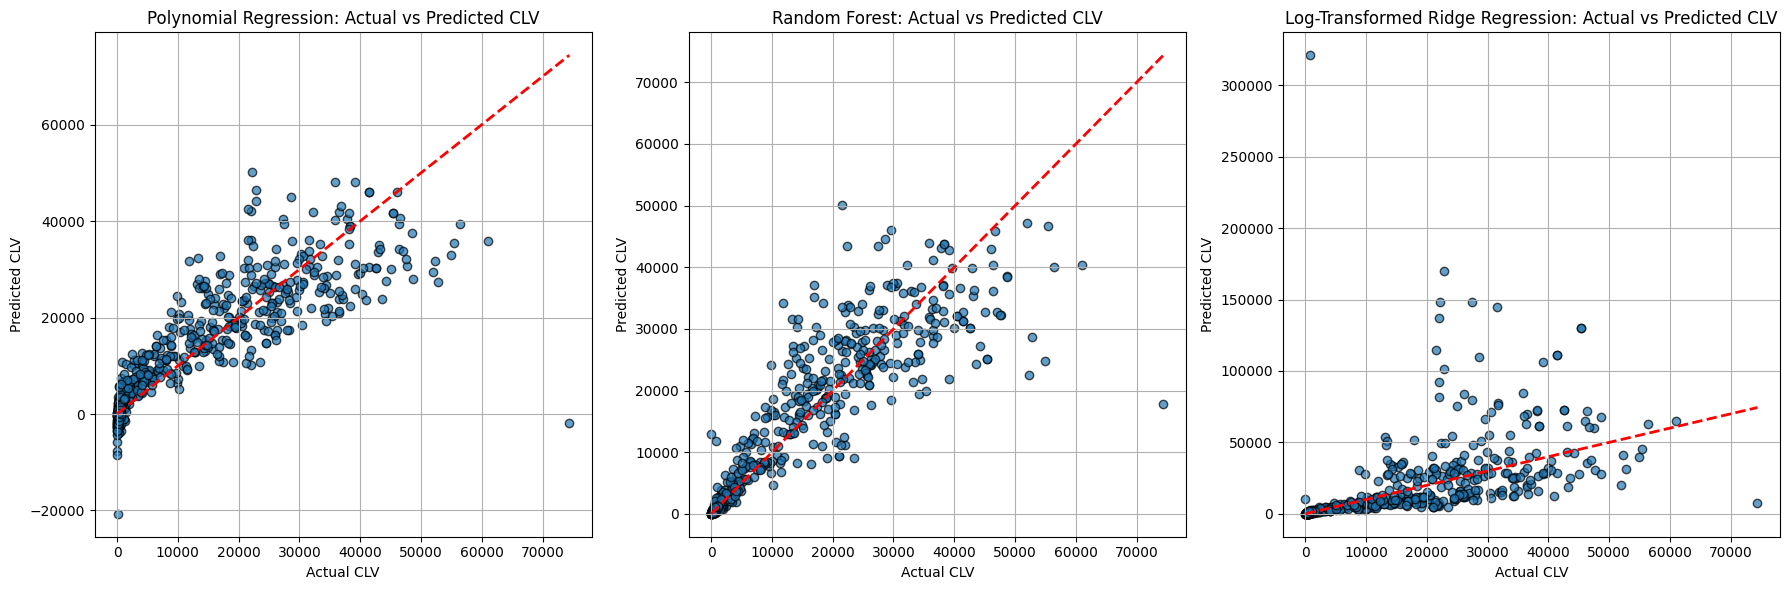

Evaluation Metrics:
Polynomial Regression:
  Mean Squared Error (MSE): 49360605.10
  R-squared (R2): 0.75

Random Forest Regression:
  Mean Squared Error (MSE): 37134549.87
  R-squared (R2): 0.81

Log-Transformed Ridge Regression:
  Mean Squared Error (MSE): 470675503.02
  R-squared (R2): -1.37


In [22]:
# Preprocessing: Handle missing values
df = df.dropna(subset=['Income']).copy()

# Feature Engineering
purchase_features = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]
df['Total_Spent'] = purchase_features.sum(axis=1)
df['Purchase_Frequency'] = (
    df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
)
df['Average_Order_Value'] = df['Total_Spent'] / df['Purchase_Frequency']
df['Recency'] = df['NumWebVisitsMonth']

# Replace infinities and drop invalid rows
df['Average_Order_Value'] = df['Average_Order_Value'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Average_Order_Value']).copy()

# Log-transform skewed variables
df['Average_Order_Value'] = np.log1p(df['Average_Order_Value'])

# Target Variable (CLV)
df['CLV'] = df['Total_Spent'] * df['Purchase_Frequency']

# Select features and target
features = ['Income', 'Recency', 'Average_Order_Value', 'Kidhome', 'Teenhome']
target = 'CLV'

# Train-test split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# =========================== Polynomial Regression ===========================
# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train Ridge Regression with Polynomial Features
poly_model = Ridge(alpha=1.0, random_state=42)
poly_model.fit(X_train_poly, y_train)

# Predict and evaluate Polynomial Regression
y_pred_poly = poly_model.predict(X_test_poly)
poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_r2 = r2_score(y_test, y_pred_poly)

# =========================== Random Forest Regression ===========================
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# =========================== Log-Transformed Ridge Regression ===========================
# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train Ridge Regression on log-transformed target
log_model = Ridge(alpha=1.0, random_state=42)
log_model.fit(X_train, y_train_log)

# Predict and inverse-transform predictions
y_pred_log = log_model.predict(X_test)
y_pred_log_exp = np.expm1(y_pred_log)
log_mse = mean_squared_error(y_test, y_pred_log_exp)
log_r2 = r2_score(y_test, y_pred_log_exp)

# =========================== Plot Results ===========================
plt.figure(figsize=(18, 6))

# Polynomial Regression plot
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_poly, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Polynomial Regression: Actual vs Predicted CLV')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.grid()

# Random Forest Regression plot
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Random Forest: Actual vs Predicted CLV')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.grid()

# Log-Transformed Ridge Regression plot
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_log_exp, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Log-Transformed Ridge Regression: Actual vs Predicted CLV')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.grid()

plt.tight_layout()
plt.show()

# =========================== Print Metrics ===========================
print("Evaluation Metrics:")
print("Polynomial Regression:")
print(f"  Mean Squared Error (MSE): {poly_mse:.2f}")
print(f"  R-squared (R2): {poly_r2:.2f}")

print("\nRandom Forest Regression:")
print(f"  Mean Squared Error (MSE): {rf_mse:.2f}")
print(f"  R-squared (R2): {rf_r2:.2f}")

print("\nLog-Transformed Ridge Regression:")
print(f"  Mean Squared Error (MSE): {log_mse:.2f}")
print(f"  R-squared (R2): {log_r2:.2f}")

## Interpretation of the Results

The evaluation metrics for the three models indicate varying levels of performance in predicting Customer Lifetime Value (CLV). Here's an analysis of each model:

### 1. Polynomial Regression
- **Mean Squared Error (MSE)**: 49,360,605.10  
- **R-squared (R²)**: 0.75  

**Analysis**:  
- This model performs reasonably well, explaining **75% of the variance** in the target (CLV).  
- The MSE is relatively high, suggesting that the model struggles with some prediction errors.  
- Polynomial regression captures non-linear relationships to some extent but may overfit due to the added complexity of polynomial features.  

---

### 2. Random Forest Regression
- **Mean Squared Error (MSE)**: 37,134,549.87  
- **R-squared (R²)**: 0.81  

**Analysis**:  
- This model outperforms the polynomial regression, explaining **81% of the variance** in CLV.  
- The lower MSE indicates better predictions with fewer errors.  
- Random forests are effective for non-linear relationships and are robust to outliers, making them a strong choice for this dataset.  

---

### 3. Log-Transformed Ridge Regression
- **Mean Squared Error (MSE)**: 470,675,503.02  
- **R-squared (R²)**: -1.37  

**Analysis**:  
- This model performs poorly, with a **negative R²**, indicating that it fails to fit the data and performs worse than a simple mean prediction.  
- The large MSE suggests significant errors in prediction.  
- The log transformation of the target likely distorted the relationship, making it harder for the Ridge model to fit the data. This may also be due to insufficient feature transformations or other data quality issues.  

---

### Model Comparison

| **Model**                  | **MSE**          | **R²**   |
|----------------------------|------------------|----------|
| **Polynomial Regression**  | 49,360,605.10   | 0.75     |
| **Random Forest Regression** | 37,134,549.87   | 0.81     |
| **Log-Transformed Ridge**  | 470,675,503.02  | -1.37    |

---

#### Best Model: **Random Forest Regression**
- It achieves the highest **R² (0.81)** and the lowest **MSE (37,134,549.87)**, indicating the best fit for this data.  
- It effectively handles the non-linear relationships and avoids overfitting.  

